# Q Function
* used to approximate the reward based on a state
* Q(s,a) calculates the expected future value from state **s** and action **a**
* in DQN, we use a **neural network to approximate the reward**

# Classes
* Environment
* Agent
* Runner

## Environment

In [1]:
class Action:
    def __init__(self, act, days, percentage):
        self.act = act
        self.days = days
        self.percentage = percentage

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

BUY = 'buy'
SELL = 'sell'
SKIP = 'skip'

class Environment:
    
    min_days_to_hold = 2
    max_days_to_hold = 15
    max_drawdowns = 3
    
    def __init__(self, 
                 ticker, 
                 initial_deposit = 100000,
                 from_date = datetime.datetime(2007, 1, 1), 
                 to_date = datetime.datetime(2017, 1, 1),
                 window = 50):
        self.initial_deposit = initial_deposit
        self.window = window
        self.data = pdr.get_data_google(ticker, from_date, to_date)
        self.pct_data = self.data.pct_change().fillna(0)
        self.data_length = len(self.data)
        
        actions = np.array([BUY, SELL, SKIP])
        days_to_holds = np.arange(Environment.min_days_to_hold, 
                                  Environment.max_days_to_hold + 1,
                                  2)
        
        self.action_space = [Action(act, days, 3) for act in actions for days in days_to_holds]
        self.reset()
        
    def reset(self):
        self.deposit = self.initial_deposit
        self.current_index = self.window
        self.actions = {}
        self.drawdowns = 0
        
        return self.state()
    
    def score(self):
        return self.deposit
    
    def enough_data_provided(self):
        return self.current_index + Environment.max_days_to_hold <= self.data_length
    
    def state(self):
        return self.pct_data.iloc[self.current_index - self.window:self.current_index]['Close']
    
    # def price_state(self):
    #    return self.data.iloc[self.current_index - self.window:self.current_index]['Close']
        
    def state_size(self):
        return self.window
    
    def action_size(self):
        return len(self.action_space)
        
    def step(self, action_idx: int):
        action = self.action_space[action_idx]
        #print('\t=> current action is: {} at {}'.format(action, self.data.index[self.current_index]))
        
        df = self.data.iloc[self.current_index: self.current_index + action.days]
        on_date = df.index[0]
        first_day_price = df.iloc[0]['Close']
        last_day_price = df.iloc[-1]['Close']
        
        if action.act == BUY:
            reward = last_day_price - first_day_price
        elif action.act == SELL:
            reward = first_day_price - last_day_price
        elif action.act == SKIP:
            reward = 0
            
        self.actions[on_date] = (action, reward)
        
        self.current_index += action.days
        self.deposit += reward * (self.deposit*action.percentage/100)
        
        if reward < 0:
            self.drawdowns += 1
        else:
            self.drawdowns = 0
        
        next_state = self.state()
        done = self.drawdowns > Environment.max_drawdowns
        _ = None
        return next_state, reward, done, _ 

## Agent

In [3]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dense(36, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Using TensorFlow backend.


## Runner

In [4]:
env = Environment('AAPL')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 21, state size: 50


In [5]:
agent = Agent(state_size, action_size)
EPISODES = 50
batch_size = 32

In [6]:
max_reward = None
for e in range(EPISODES):
    print('==> EPISODE {}'.format(e))
    state = env.reset()
    state = state.values.reshape([1, state_size])
    while env.enough_data_provided():
        action_idx = agent.act(state)
        next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
        # reward = reward if not done else -10
        next_state = next_state.values.reshape([1, state_size])
        agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
        
        if done:
            agent.update_target_model()
            break
        elif len(agent.memory) > batch_size:
            agent.replay(batch_size)
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, env.score(), agent.epsilon))
    
    if max_reward is None or max_reward[0] < env.score():
        max_reward = (env.score(), env.actions)

==> EPISODE 0
episode: 0/50, score: 114462.03443173149, e: 1.0
episode: 0/50, score: 113225.8444598688, e: 1.0
episode: 0/50, score: 105379.29343879988, e: 1.0
episode: 0/50, score: 104462.49358588233, e: 1.0
episode: 0/50, score: 104462.49358588233, e: 1.0
episode: 0/50, score: 104462.49358588233, e: 0.99
episode: 0/50, score: 104462.49358588233, e: 0.99
episode: 0/50, score: 106060.76973774633, e: 0.99
episode: 0/50, score: 106474.40673972355, e: 0.99
episode: 0/50, score: 106474.40673972355, e: 0.99
episode: 0/50, score: 105548.07940108796, e: 0.99
episode: 0/50, score: 105548.07940108796, e: 0.99
episode: 0/50, score: 104249.83802445458, e: 0.99
episode: 0/50, score: 107002.03374830018, e: 0.99
episode: 0/50, score: 103535.16785485524, e: 0.99
episode: 0/50, score: 103535.16785485524, e: 0.98
episode: 0/50, score: 104032.13666055855, e: 0.98
episode: 0/50, score: 96573.0324619965, e: 0.98
episode: 0/50, score: 96573.0324619965, e: 0.98
episode: 0/50, score: 81246.89221027764, e: 0.

episode: 0/50, score: 206316.2854208381, e: 0.85
episode: 0/50, score: 206316.2854208381, e: 0.84
episode: 0/50, score: 220490.21422924972, e: 0.84
episode: 0/50, score: 205673.27183304416, e: 0.84
episode: 0/50, score: 184694.5981060737, e: 0.84
episode: 0/50, score: 184694.5981060737, e: 0.84
episode: 0/50, score: 187908.28411311947, e: 0.84
episode: 0/50, score: 188979.36133256424, e: 0.84
episode: 0/50, score: 196803.10689173246, e: 0.84
episode: 0/50, score: 189659.15411156253, e: 0.84
episode: 0/50, score: 187269.44876975683, e: 0.84
episode: 0/50, score: 187269.44876975683, e: 0.84
episode: 0/50, score: 193730.24475231348, e: 0.84
episode: 0/50, score: 193730.24475231348, e: 0.83
episode: 0/50, score: 230403.38008392634, e: 0.83
episode: 0/50, score: 248513.08575852297, e: 0.83
episode: 0/50, score: 243219.75703186647, e: 0.83
episode: 0/50, score: 257667.01059955938, e: 0.83
episode: 0/50, score: 257667.01059955938, e: 0.83
episode: 0/50, score: 257667.01059955938, e: 0.83
epis

episode: 3/50, score: 109842.30061605065, e: 0.72
episode: 3/50, score: 109150.29412216952, e: 0.71
episode: 3/50, score: 103649.11929841217, e: 0.71
==> EPISODE 4
episode: 4/50, score: 98320.0, e: 0.71
episode: 4/50, score: 98968.912, e: 0.71
episode: 4/50, score: 99859.632208, e: 0.71
episode: 4/50, score: 101207.737242808, e: 0.71
episode: 4/50, score: 104972.66506824046, e: 0.71
episode: 4/50, score: 110137.32018959789, e: 0.71
episode: 4/50, score: 110599.89693439419, e: 0.71
episode: 4/50, score: 109239.51820210114, e: 0.71
episode: 4/50, score: 109239.51820210114, e: 0.71
episode: 4/50, score: 109436.14933486494, e: 0.71
episode: 4/50, score: 105791.92556201394, e: 0.71
episode: 4/50, score: 102110.36655245586, e: 0.71
episode: 4/50, score: 100272.37995451165, e: 0.7
episode: 4/50, score: 100904.09594822508, e: 0.7
episode: 4/50, score: 103386.33670855142, e: 0.7
episode: 4/50, score: 105092.21126424252, e: 0.7
episode: 4/50, score: 105092.21126424252, e: 0.7
episode: 4/50, scor

episode: 4/50, score: 177988.89552512162, e: 0.61
episode: 4/50, score: 179323.81224156002, e: 0.61
episode: 4/50, score: 168295.3977887041, e: 0.6
episode: 4/50, score: 159661.8438821436, e: 0.6
episode: 4/50, score: 152716.55367327036, e: 0.6
==> EPISODE 5
episode: 5/50, score: 102520.0, e: 0.6
episode: 5/50, score: 102704.53600000001, e: 0.6
episode: 5/50, score: 102704.53600000001, e: 0.6
episode: 5/50, score: 100516.92938320001, e: 0.6
episode: 5/50, score: 100516.92938320001, e: 0.6
episode: 5/50, score: 103502.28218588105, e: 0.6
episode: 5/50, score: 103502.28218588105, e: 0.6
episode: 5/50, score: 102570.76164620812, e: 0.6
episode: 5/50, score: 99247.46896887098, e: 0.6
episode: 5/50, score: 96954.85243569006, e: 0.6
==> EPISODE 6
episode: 6/50, score: 101740.0, e: 0.6
episode: 6/50, score: 99908.68000000001, e: 0.6
episode: 6/50, score: 103715.200708, e: 0.6
episode: 6/50, score: 100572.6301265476, e: 0.59
episode: 6/50, score: 101176.0659073069, e: 0.59
episode: 6/50, score

episode: 10/50, score: 115998.90255211787, e: 0.51
episode: 10/50, score: 126056.0074033865, e: 0.51
episode: 10/50, score: 124921.50333675601, e: 0.51
episode: 10/50, score: 124921.50333675601, e: 0.51
episode: 10/50, score: 130093.25357489771, e: 0.51
episode: 10/50, score: 130093.25357489771, e: 0.51
episode: 10/50, score: 127361.29524982486, e: 0.51
episode: 10/50, score: 127361.29524982486, e: 0.51
episode: 10/50, score: 127361.29524982486, e: 0.51
episode: 10/50, score: 124533.87449527874, e: 0.51
episode: 10/50, score: 121432.98102034628, e: 0.51
episode: 10/50, score: 117170.68338653214, e: 0.51
episode: 10/50, score: 118365.82435707477, e: 0.51
episode: 10/50, score: 118365.82435707477, e: 0.51
episode: 10/50, score: 118365.82435707477, e: 0.51
episode: 10/50, score: 122520.4647920081, e: 0.5
episode: 10/50, score: 122520.4647920081, e: 0.5
episode: 10/50, score: 122520.4647920081, e: 0.5
episode: 10/50, score: 127592.81203439724, e: 0.5
episode: 10/50, score: 126329.643195256

episode: 11/50, score: 122402.15598559345, e: 0.44
episode: 11/50, score: 122402.15598559345, e: 0.43
episode: 11/50, score: 129195.47564279388, e: 0.43
episode: 11/50, score: 129195.47564279388, e: 0.43
episode: 11/50, score: 148458.52106113444, e: 0.43
episode: 11/50, score: 178343.22135074085, e: 0.43
episode: 11/50, score: 166251.5509431606, e: 0.43
episode: 11/50, score: 204755.4101415966, e: 0.43
episode: 11/50, score: 211328.0588071419, e: 0.43
episode: 11/50, score: 212279.03507177398, e: 0.43
episode: 11/50, score: 212279.03507177398, e: 0.43
episode: 11/50, score: 210241.1563350849, e: 0.43
episode: 11/50, score: 192391.6821622362, e: 0.43
episode: 11/50, score: 204627.79314775445, e: 0.43
episode: 11/50, score: 197445.35760826827, e: 0.43
episode: 11/50, score: 197919.2264665281, e: 0.43
episode: 11/50, score: 197919.2264665281, e: 0.43
episode: 11/50, score: 208072.48278426105, e: 0.43
episode: 11/50, score: 202392.10400425075, e: 0.43
episode: 11/50, score: 204092.19767788

episode: 13/50, score: 161935.60563756706, e: 0.37
episode: 13/50, score: 173254.904471633, e: 0.37
episode: 13/50, score: 191030.85767042256, e: 0.37
episode: 13/50, score: 185128.00416840648, e: 0.37
episode: 13/50, score: 185128.00416840648, e: 0.37
episode: 13/50, score: 185350.15777340857, e: 0.37
episode: 13/50, score: 183904.42654277597, e: 0.37
episode: 13/50, score: 186883.67825276894, e: 0.37
episode: 13/50, score: 186883.67825276894, e: 0.37
episode: 13/50, score: 182006.0142503717, e: 0.37
episode: 13/50, score: 182006.0142503717, e: 0.37
episode: 13/50, score: 183152.65214014903, e: 0.37
episode: 13/50, score: 184361.459644274, e: 0.37
episode: 13/50, score: 184361.459644274, e: 0.36
episode: 13/50, score: 191994.02407354696, e: 0.36
episode: 13/50, score: 198502.62148964018, e: 0.36
episode: 13/50, score: 198502.62148964018, e: 0.36
episode: 13/50, score: 201241.9576661972, e: 0.36
episode: 13/50, score: 187899.61587292832, e: 0.36
episode: 13/50, score: 191507.2884976885

episode: 14/50, score: 345240.40041533444, e: 0.31
episode: 14/50, score: 349486.85734044306, e: 0.31
episode: 14/50, score: 339945.866135049, e: 0.31
episode: 14/50, score: 346370.84300500137, e: 0.31
episode: 14/50, score: 346370.84300500137, e: 0.31
episode: 14/50, score: 358216.7258357724, e: 0.31
episode: 14/50, score: 358216.7258357724, e: 0.31
episode: 14/50, score: 349512.05939796317, e: 0.31
episode: 14/50, score: 349512.05939796317, e: 0.31
episode: 14/50, score: 368805.12507673074, e: 0.31
episode: 14/50, score: 368141.2758515926, e: 0.31
episode: 14/50, score: 368141.2758515926, e: 0.31
episode: 14/50, score: 379406.3988926513, e: 0.31
episode: 14/50, score: 358804.63143278036, e: 0.31
episode: 14/50, score: 345457.09914348094, e: 0.31
episode: 14/50, score: 329704.2554225382, e: 0.31
==> EPISODE 15
episode: 15/50, score: 101680.0, e: 0.31
episode: 15/50, score: 100276.816, e: 0.31
episode: 15/50, score: 101058.97516480001, e: 0.31
episode: 15/50, score: 102423.27132952481,

episode: 16/50, score: 145524.9264274726, e: 0.27
episode: 16/50, score: 160936.01613614193, e: 0.27
episode: 16/50, score: 168467.82169131338, e: 0.27
episode: 16/50, score: 168467.82169131338, e: 0.27
episode: 16/50, score: 167709.71649370246, e: 0.27
episode: 16/50, score: 162426.86042415083, e: 0.27
episode: 16/50, score: 156969.31791389934, e: 0.27
==> EPISODE 17
episode: 17/50, score: 97990.0, e: 0.27
episode: 17/50, score: 96137.989, e: 0.26
episode: 17/50, score: 100002.7361578, e: 0.26
episode: 17/50, score: 104802.86749337439, e: 0.26
episode: 17/50, score: 108890.17932561599, e: 0.26
episode: 17/50, score: 108759.51111042526, e: 0.26
episode: 17/50, score: 108759.51111042526, e: 0.26
episode: 17/50, score: 108759.51111042526, e: 0.26
episode: 17/50, score: 104583.14588378492, e: 0.26
episode: 17/50, score: 105273.3946466179, e: 0.26
episode: 17/50, score: 106252.43721683144, e: 0.26
episode: 17/50, score: 99239.77636052057, e: 0.26
episode: 17/50, score: 100490.19754266313, 

episode: 19/50, score: 254191.76043882727, e: 0.23
episode: 19/50, score: 241456.75324084202, e: 0.23
episode: 19/50, score: 192344.44963165474, e: 0.23
episode: 19/50, score: 172956.12910878396, e: 0.23
episode: 19/50, score: 187743.878147585, e: 0.23
episode: 19/50, score: 187743.878147585, e: 0.23
episode: 19/50, score: 198163.66338477598, e: 0.23
episode: 19/50, score: 198163.66338477598, e: 0.23
episode: 19/50, score: 227888.2128924924, e: 0.22
episode: 19/50, score: 232673.86536323474, e: 0.22
episode: 19/50, score: 278254.6755878924, e: 0.22
episode: 19/50, score: 278254.6755878924, e: 0.22
episode: 19/50, score: 347206.1841985722, e: 0.22
episode: 19/50, score: 347206.1841985722, e: 0.22
episode: 19/50, score: 347206.1841985722, e: 0.22
episode: 19/50, score: 347206.1841985722, e: 0.22
episode: 19/50, score: 347206.1841985722, e: 0.22
episode: 19/50, score: 338560.75021202763, e: 0.22
episode: 19/50, score: 361718.3055265303, e: 0.22
episode: 19/50, score: 361718.3055265303, e:

episode: 20/50, score: 435922.61615592113, e: 0.19
episode: 20/50, score: 507195.9638974143, e: 0.19
episode: 20/50, score: 547061.5666597511, e: 0.19
episode: 20/50, score: 713149.4582976516, e: 0.19
episode: 20/50, score: 769203.0057198472, e: 0.19
episode: 20/50, score: 690975.0600381386, e: 0.19
episode: 20/50, score: 529494.1885072255, e: 0.19
episode: 20/50, score: 563328.8671528371, e: 0.19
episode: 20/50, score: 507390.3106445603, e: 0.19
episode: 20/50, score: 551076.6163910568, e: 0.19
episode: 20/50, score: 581661.3686007606, e: 0.19
episode: 20/50, score: 695783.3291202299, e: 0.19
episode: 20/50, score: 856926.7481444752, e: 0.19
episode: 20/50, score: 887004.8770043459, e: 0.19
episode: 20/50, score: 887004.8770043459, e: 0.19
episode: 20/50, score: 880086.2389637122, e: 0.19
episode: 20/50, score: 1117181.4717405364, e: 0.19
episode: 20/50, score: 1281742.3025279173, e: 0.19
episode: 20/50, score: 1660112.6302341586, e: 0.19
episode: 20/50, score: 1468369.6214421135, e: 

episode: 23/50, score: 119336.34660891918, e: 0.16
episode: 23/50, score: 121914.01169567184, e: 0.16
episode: 23/50, score: 129521.44602548175, e: 0.16
episode: 23/50, score: 129521.44602548175, e: 0.16
episode: 23/50, score: 138652.70797027822, e: 0.16
episode: 23/50, score: 147096.65788566816, e: 0.16
episode: 23/50, score: 156849.16630348796, e: 0.16
episode: 23/50, score: 157460.87805207155, e: 0.16
episode: 23/50, score: 164688.33235466163, e: 0.16
episode: 23/50, score: 164688.33235466163, e: 0.16
episode: 23/50, score: 161773.3488719841, e: 0.16
episode: 23/50, score: 169975.2576597937, e: 0.16
episode: 23/50, score: 169975.2576597937, e: 0.16
episode: 23/50, score: 183080.3500253638, e: 0.16
episode: 23/50, score: 213563.22830458687, e: 0.16
episode: 23/50, score: 211961.50409230246, e: 0.16
episode: 23/50, score: 208400.55082355178, e: 0.16
episode: 23/50, score: 222280.02750840032, e: 0.16
episode: 23/50, score: 218278.9870132491, e: 0.16
episode: 23/50, score: 236483.454530

episode: 24/50, score: 346418.6841684311, e: 0.14
episode: 24/50, score: 351926.74124670913, e: 0.14
episode: 24/50, score: 377265.4666164722, e: 0.14
episode: 24/50, score: 375115.0534567583, e: 0.14
episode: 24/50, score: 381979.658935017, e: 0.14
episode: 24/50, score: 381979.658935017, e: 0.14
episode: 24/50, score: 381979.658935017, e: 0.14
episode: 24/50, score: 381750.47113965603, e: 0.14
episode: 24/50, score: 395264.43781799986, e: 0.14
episode: 24/50, score: 384355.13933422306, e: 0.14
episode: 24/50, score: 384355.13933422306, e: 0.14
episode: 24/50, score: 405917.46265087294, e: 0.14
episode: 24/50, score: 386068.09872724523, e: 0.14
episode: 24/50, score: 402514.5997330259, e: 0.14
episode: 24/50, score: 402514.5997330259, e: 0.14
episode: 24/50, score: 431254.14215396397, e: 0.14
episode: 24/50, score: 431254.14215396397, e: 0.14
episode: 24/50, score: 432289.15209513344, e: 0.14
episode: 24/50, score: 481181.05519709305, e: 0.14
episode: 24/50, score: 410591.7943996795, 

episode: 25/50, score: 97549.045, e: 0.12
episode: 25/50, score: 97549.045, e: 0.12
episode: 25/50, score: 97988.0157025, e: 0.12
episode: 25/50, score: 101809.54831489749, e: 0.12
episode: 25/50, score: 103367.23440411541, e: 0.12
episode: 25/50, score: 106437.24126591765, e: 0.12
episode: 25/50, score: 110588.29367528844, e: 0.12
episode: 25/50, score: 110588.29367528844, e: 0.12
episode: 25/50, score: 115000.76659293244, e: 0.12
episode: 25/50, score: 112758.25164437026, e: 0.12
episode: 25/50, score: 118001.51034583348, e: 0.12
episode: 25/50, score: 121647.75701551973, e: 0.12
episode: 25/50, score: 121647.75701551973, e: 0.12
episode: 25/50, score: 130515.87850195111, e: 0.12
episode: 25/50, score: 137015.56925134826, e: 0.12
episode: 25/50, score: 139153.0121316693, e: 0.12
episode: 25/50, score: 149547.74213790498, e: 0.12
episode: 25/50, score: 142638.63645113376, e: 0.12
episode: 25/50, score: 141996.76258710367, e: 0.12
episode: 25/50, score: 151070.35571641958, e: 0.12
epis

episode: 25/50, score: 364436.0805117566, e: 0.1
episode: 25/50, score: 412978.9664359226, e: 0.1
episode: 25/50, score: 412978.9664359226, e: 0.1
episode: 25/50, score: 412978.9664359226, e: 0.1
episode: 25/50, score: 530801.8655600913, e: 0.1
episode: 25/50, score: 461213.74098516325, e: 0.099
episode: 25/50, score: 476572.15855996916, e: 0.099
episode: 25/50, score: 449264.573874483, e: 0.099
episode: 25/50, score: 449264.573874483, e: 0.099
episode: 25/50, score: 449264.573874483, e: 0.099
episode: 25/50, score: 402765.69047847396, e: 0.099
episode: 25/50, score: 447714.34153587173, e: 0.099
episode: 25/50, score: 451340.82770231226, e: 0.099
episode: 25/50, score: 494263.3404168022, e: 0.099
episode: 25/50, score: 479880.27721067326, e: 0.099
episode: 25/50, score: 414376.6193714164, e: 0.098
episode: 25/50, score: 460496.73710745515, e: 0.098
episode: 25/50, score: 475416.8313897367, e: 0.098
episode: 25/50, score: 478982.4576251597, e: 0.098
episode: 25/50, score: 485592.4155403

episode: 27/50, score: 109336.36932352284, e: 0.085
episode: 27/50, score: 111107.61850656391, e: 0.085
episode: 27/50, score: 118507.38589910106, e: 0.085
episode: 27/50, score: 127964.27529384934, e: 0.085
episode: 27/50, score: 139596.22791806023, e: 0.085
episode: 27/50, score: 144956.72307011375, e: 0.085
episode: 27/50, score: 157741.90604489777, e: 0.085
episode: 27/50, score: 186608.67485111408, e: 0.084
episode: 27/50, score: 182521.94487187467, e: 0.084
episode: 27/50, score: 178743.74061302686, e: 0.084
episode: 27/50, score: 182390.11292153262, e: 0.084
episode: 27/50, score: 182390.11292153262, e: 0.084
episode: 27/50, score: 173525.95343354612, e: 0.084
episode: 27/50, score: 167747.53918420905, e: 0.084
episode: 27/50, score: 174088.39616537216, e: 0.084
episode: 27/50, score: 178579.87678643875, e: 0.084
episode: 27/50, score: 191544.77584113422, e: 0.084
episode: 27/50, score: 191544.77584113422, e: 0.084
episode: 27/50, score: 198038.14374214868, e: 0.084
episode: 27/

episode: 30/50, score: 112263.65656842939, e: 0.072
episode: 30/50, score: 112263.65656842939, e: 0.072
episode: 30/50, score: 112263.65656842939, e: 0.072
episode: 30/50, score: 111286.96275628406, e: 0.072
episode: 30/50, score: 111286.96275628406, e: 0.072
episode: 30/50, score: 111286.96275628406, e: 0.072
episode: 30/50, score: 112221.77324343685, e: 0.072
episode: 30/50, score: 112221.77324343685, e: 0.072
episode: 30/50, score: 106498.46280802158, e: 0.072
episode: 30/50, score: 99565.41287921937, e: 0.072
episode: 30/50, score: 89887.65474735925, e: 0.072
==> EPISODE 31
episode: 31/50, score: 101680.0, e: 0.072
episode: 31/50, score: 100734.376, e: 0.072
episode: 31/50, score: 98951.37754480001, e: 0.072
episode: 31/50, score: 98951.37754480001, e: 0.071
episode: 31/50, score: 98951.37754480001, e: 0.071
episode: 31/50, score: 100762.18775386985, e: 0.071
episode: 31/50, score: 100762.18775386985, e: 0.071
episode: 31/50, score: 102606.13578976566, e: 0.071
episode: 31/50, scor

episode: 31/50, score: 500730.7484999597, e: 0.062
episode: 31/50, score: 637430.2428404486, e: 0.062
episode: 31/50, score: 637430.2428404486, e: 0.062
episode: 31/50, score: 604347.6132370293, e: 0.062
episode: 31/50, score: 582047.1863085831, e: 0.061
episode: 31/50, score: 535774.4349970509, e: 0.061
==> EPISODE 32
episode: 32/50, score: 102520.0, e: 0.061
episode: 32/50, score: 103780.996, e: 0.061
episode: 32/50, score: 105182.039446, e: 0.061
episode: 32/50, score: 102184.351321789, e: 0.061
episode: 32/50, score: 106384.12816111452, e: 0.061
episode: 32/50, score: 112128.87108181471, e: 0.061
episode: 32/50, score: 113777.16548671738, e: 0.061
episode: 32/50, score: 113743.03233707136, e: 0.061
episode: 32/50, score: 113743.03233707136, e: 0.061
episode: 32/50, score: 122307.88267205283, e: 0.061
episode: 32/50, score: 120289.80260796395, e: 0.061
episode: 32/50, score: 121047.62836439413, e: 0.061
episode: 32/50, score: 121955.48557712708, e: 0.061
episode: 32/50, score: 12799

episode: 32/50, score: 1929467.9928835363, e: 0.053
episode: 32/50, score: 2125694.887759792, e: 0.052
episode: 32/50, score: 2125694.887759792, e: 0.052
episode: 32/50, score: 2056822.3733963745, e: 0.052
episode: 32/50, score: 2056822.3733963745, e: 0.052
episode: 32/50, score: 2174061.2486799676, e: 0.052
episode: 32/50, score: 1759902.5808064337, e: 0.052
episode: 32/50, score: 1759902.5808064337, e: 0.052
episode: 32/50, score: 1494333.281362743, e: 0.052
episode: 32/50, score: 1550819.0793982549, e: 0.052
episode: 32/50, score: 1548492.850779157, e: 0.052
episode: 32/50, score: 1782624.969816965, e: 0.052
episode: 32/50, score: 1782624.969816965, e: 0.052
episode: 32/50, score: 1892256.4054607083, e: 0.052
episode: 32/50, score: 1714005.8520663097, e: 0.052
episode: 32/50, score: 1666699.2905492794, e: 0.052
episode: 32/50, score: 1655199.0654444892, e: 0.052
==> EPISODE 33
episode: 33/50, score: 98230.0, e: 0.052
episode: 33/50, score: 97169.116, e: 0.052
episode: 33/50, score: 

episode: 34/50, score: 236271.27831664434, e: 0.05
episode: 34/50, score: 236271.27831664434, e: 0.05
episode: 34/50, score: 246052.90923895343, e: 0.05
episode: 34/50, score: 246052.90923895343, e: 0.05
episode: 34/50, score: 246052.90923895343, e: 0.05
episode: 34/50, score: 260447.0044294322, e: 0.05
episode: 34/50, score: 260447.0044294322, e: 0.05
episode: 34/50, score: 260447.0044294322, e: 0.05
episode: 34/50, score: 260447.0044294322, e: 0.05
episode: 34/50, score: 260447.0044294322, e: 0.05
episode: 34/50, score: 256462.1652616619, e: 0.05
episode: 34/50, score: 260078.28179185133, e: 0.05
episode: 34/50, score: 262340.9628434404, e: 0.05
episode: 34/50, score: 270762.1077507149, e: 0.05
episode: 34/50, score: 262558.0158858682, e: 0.05
episode: 34/50, score: 252712.09029014816, e: 0.05
episode: 34/50, score: 249603.73157957933, e: 0.05
==> EPISODE 35
episode: 35/50, score: 102010.0, e: 0.05
episode: 35/50, score: 102010.0, e: 0.05
episode: 35/50, score: 100326.83499999999, e:

episode: 35/50, score: 1257805.0395641802, e: 0.05
episode: 35/50, score: 1257805.0395641802, e: 0.05
episode: 35/50, score: 1220825.5714009937, e: 0.05
episode: 35/50, score: 1129263.653545919, e: 0.05
episode: 35/50, score: 1129263.653545919, e: 0.05
episode: 35/50, score: 1162464.0049601693, e: 0.05
episode: 35/50, score: 1289056.3351003318, e: 0.05
episode: 35/50, score: 1187349.7902609156, e: 0.05
episode: 35/50, score: 1187349.7902609156, e: 0.05
episode: 35/50, score: 1022070.6994565964, e: 0.05
episode: 35/50, score: 865693.8824397371, e: 0.05
episode: 35/50, score: 865693.8824397371, e: 0.05
episode: 35/50, score: 899715.6520196187, e: 0.05
episode: 35/50, score: 929406.2685362663, e: 0.05
episode: 35/50, score: 822896.3101620101, e: 0.05
episode: 35/50, score: 741429.5754559712, e: 0.05
episode: 35/50, score: 836629.1329445179, e: 0.05
episode: 35/50, score: 846668.6825398521, e: 0.05
episode: 35/50, score: 930234.8815065357, e: 0.05
episode: 35/50, score: 1150142.4074946805,

episode: 36/50, score: 677093.140047113, e: 0.05
episode: 36/50, score: 744328.4888537913, e: 0.05
episode: 36/50, score: 771347.6129991839, e: 0.05
episode: 36/50, score: 802124.3827578514, e: 0.05
episode: 36/50, score: 845920.3740564301, e: 0.05
episode: 36/50, score: 852772.3290862872, e: 0.05
episode: 36/50, score: 852772.3290862872, e: 0.05
episode: 36/50, score: 865052.2506251298, e: 0.05
episode: 36/50, score: 932007.2948235148, e: 0.05
episode: 36/50, score: 956612.2874068554, e: 0.05
episode: 36/50, score: 956612.2874068554, e: 0.05
episode: 36/50, score: 951159.5973686364, e: 0.05
episode: 36/50, score: 968565.8180004824, e: 0.05
episode: 36/50, score: 989196.2699238927, e: 0.05
episode: 36/50, score: 1088907.253932221, e: 0.05
episode: 36/50, score: 1158488.42745849, e: 0.05
episode: 36/50, score: 1107399.0878075704, e: 0.05
episode: 36/50, score: 1067864.9403728403, e: 0.05
episode: 36/50, score: 1097017.6532450188, e: 0.05
episode: 36/50, score: 1270785.2495190299, e: 0.0

episode: 37/50, score: 472223.2108434413, e: 0.05
episode: 37/50, score: 472223.2108434413, e: 0.05
episode: 37/50, score: 473498.21351271856, e: 0.05
episode: 37/50, score: 498925.06757835153, e: 0.05
episode: 37/50, score: 500721.19782163366, e: 0.05
episode: 37/50, score: 521000.40633340983, e: 0.05
episode: 37/50, score: 464263.46208370145, e: 0.05
episode: 37/50, score: 472620.204401208, e: 0.05
episode: 37/50, score: 497716.3372549122, e: 0.05
episode: 37/50, score: 490250.5921960885, e: 0.05
episode: 37/50, score: 516282.89864170074, e: 0.05
episode: 37/50, score: 521084.3295990686, e: 0.05
episode: 37/50, score: 521084.3295990686, e: 0.05
episode: 37/50, score: 512173.78756292467, e: 0.05
episode: 37/50, score: 562110.7318503099, e: 0.05
episode: 37/50, score: 655533.5354838314, e: 0.05
episode: 37/50, score: 623674.6056593172, e: 0.05
episode: 37/50, score: 632094.212835718, e: 0.05
episode: 37/50, score: 604977.3711050657, e: 0.05
episode: 37/50, score: 604977.3711050657, e: 

episode: 41/50, score: 147520.02122025628, e: 0.05
episode: 41/50, score: 148360.88534121175, e: 0.05
episode: 41/50, score: 164339.35269246026, e: 0.05
episode: 41/50, score: 172227.64162169833, e: 0.05
episode: 41/50, score: 175534.41234083494, e: 0.05
episode: 41/50, score: 178378.06982075647, e: 0.05
episode: 41/50, score: 172598.62035856396, e: 0.05
episode: 41/50, score: 178346.15441650414, e: 0.05
episode: 41/50, score: 166307.7889933901, e: 0.05
episode: 41/50, score: 166307.7889933901, e: 0.05
episode: 41/50, score: 166208.00431999407, e: 0.05
episode: 41/50, score: 141426.39087588296, e: 0.05
episode: 41/50, score: 159415.82779529528, e: 0.05
episode: 41/50, score: 164676.55011254002, e: 0.05
episode: 41/50, score: 167097.29539919435, e: 0.05
episode: 41/50, score: 168801.68781226614, e: 0.05
episode: 41/50, score: 167079.91059658103, e: 0.05
episode: 41/50, score: 166929.5386770441, e: 0.05
episode: 41/50, score: 173840.42157827373, e: 0.05
episode: 41/50, score: 167999.3834

episode: 41/50, score: 1708686.4252620093, e: 0.05
episode: 41/50, score: 2235132.712885234, e: 0.05
episode: 41/50, score: 2246531.889720948, e: 0.05
episode: 41/50, score: 2667082.659476709, e: 0.05
episode: 41/50, score: 2599872.176457896, e: 0.05
episode: 41/50, score: 2743385.120598372, e: 0.05
episode: 41/50, score: 3109627.034198254, e: 0.05
episode: 41/50, score: 3020069.7756133447, e: 0.05
episode: 41/50, score: 3068994.9059782815, e: 0.05
episode: 41/50, score: 3695069.866797852, e: 0.05
episode: 41/50, score: 3777100.4178407635, e: 0.05
episode: 41/50, score: 3636592.282297088, e: 0.05
episode: 41/50, score: 3636592.282297088, e: 0.05
episode: 41/50, score: 4106803.6643981016, e: 0.05
episode: 41/50, score: 5023442.24229176, e: 0.05
episode: 41/50, score: 5315806.580793142, e: 0.05
episode: 41/50, score: 4724157.308350867, e: 0.05
episode: 41/50, score: 4664632.926265646, e: 0.05
episode: 41/50, score: 4822763.98246605, e: 0.05
episode: 41/50, score: 6039547.335242234, e: 0.

episode: 43/50, score: 119616.93149299714, e: 0.05
episode: 43/50, score: 126793.94738257697, e: 0.05
episode: 43/50, score: 126641.79464571788, e: 0.05
episode: 43/50, score: 137697.62331828906, e: 0.05
episode: 43/50, score: 157567.39036311817, e: 0.05
episode: 43/50, score: 167257.78487044992, e: 0.05
episode: 43/50, score: 169616.11963712325, e: 0.05
episode: 43/50, score: 173686.90650841422, e: 0.05
episode: 43/50, score: 182440.7265964383, e: 0.05
episode: 43/50, score: 196397.44218106582, e: 0.05
episode: 43/50, score: 221732.71222242332, e: 0.05
episode: 43/50, score: 229249.45116676347, e: 0.05
episode: 43/50, score: 229249.45116676347, e: 0.05
episode: 43/50, score: 245136.43813262015, e: 0.05
episode: 43/50, score: 239841.49106895557, e: 0.05
episode: 43/50, score: 267399.2783927786, e: 0.05
episode: 43/50, score: 258013.56372119207, e: 0.05
episode: 43/50, score: 262270.78752259177, e: 0.05
episode: 43/50, score: 273600.88554356777, e: 0.05
episode: 43/50, score: 274832.089

episode: 43/50, score: 4274811.088910726, e: 0.05
episode: 43/50, score: 4161956.0761634815, e: 0.05
episode: 43/50, score: 5024729.570752171, e: 0.05
episode: 43/50, score: 4904136.061054119, e: 0.05
episode: 43/50, score: 4768781.905769025, e: 0.05
episode: 43/50, score: 5107842.299269203, e: 0.05
episode: 43/50, score: 5107842.299269203, e: 0.05
episode: 43/50, score: 5981283.332444235, e: 0.05
episode: 43/50, score: 7113540.267275926, e: 0.05
episode: 43/50, score: 7672664.532283815, e: 0.05
episode: 43/50, score: 7672664.532283815, e: 0.05
episode: 43/50, score: 7663457.334845073, e: 0.05
episode: 43/50, score: 7764614.971665027, e: 0.05
episode: 43/50, score: 7764614.971665027, e: 0.05
episode: 43/50, score: 10212798.072231011, e: 0.05
episode: 43/50, score: 10264883.342399387, e: 0.05
episode: 43/50, score: 12186469.50409655, e: 0.05
episode: 43/50, score: 12493568.535599785, e: 0.05
episode: 43/50, score: 13183213.518764894, e: 0.05
episode: 43/50, score: 14943172.523520004, e:

episode: 45/50, score: 308044.4547881299, e: 0.05
episode: 45/50, score: 347227.70943718, e: 0.05
episode: 45/50, score: 325039.8588041442, e: 0.05
episode: 45/50, score: 337618.9013398646, e: 0.05
episode: 45/50, score: 356154.1790234232, e: 0.05
episode: 45/50, score: 361069.1066939464, e: 0.05
episode: 45/50, score: 346662.44933685794, e: 0.05
episode: 45/50, score: 361014.27473940386, e: 0.05
episode: 45/50, score: 380400.74129290984, e: 0.05
episode: 45/50, score: 348332.9588019175, e: 0.05
episode: 45/50, score: 358573.9477906939, e: 0.05
episode: 45/50, score: 372988.6204918798, e: 0.05
episode: 45/50, score: 364036.8936000747, e: 0.05
episode: 45/50, score: 359559.23980879376, e: 0.05
episode: 45/50, score: 374768.59565270576, e: 0.05
episode: 45/50, score: 386911.0981518534, e: 0.05
episode: 45/50, score: 385053.9248807245, e: 0.05
episode: 45/50, score: 376390.2115709082, e: 0.05
episode: 45/50, score: 376390.2115709082, e: 0.05
episode: 45/50, score: 397957.3706939212, e: 0.

episode: 47/50, score: 126104.82702844254, e: 0.05
episode: 47/50, score: 141010.41758320446, e: 0.05
episode: 47/50, score: 143210.18009750245, e: 0.05
episode: 47/50, score: 151502.04952514786, e: 0.05
episode: 47/50, score: 164364.5735298329, e: 0.05
episode: 47/50, score: 174867.46977838923, e: 0.05
episode: 47/50, score: 164008.19990515127, e: 0.05
episode: 47/50, score: 164008.19990515127, e: 0.05
episode: 47/50, score: 178473.72313678561, e: 0.05
episode: 47/50, score: 211134.41447081737, e: 0.05
episode: 47/50, score: 206510.57079390646, e: 0.05
episode: 47/50, score: 202235.80197847262, e: 0.05
episode: 47/50, score: 200355.00902007284, e: 0.05
episode: 47/50, score: 218206.64032376133, e: 0.05
episode: 47/50, score: 210154.81529581454, e: 0.05
episode: 47/50, score: 232914.58179235124, e: 0.05
episode: 47/50, score: 236478.1748937742, e: 0.05
episode: 47/50, score: 237897.04394313684, e: 0.05
episode: 47/50, score: 230189.17971937923, e: 0.05
episode: 47/50, score: 237854.479

episode: 47/50, score: 2466670.9530443726, e: 0.05
episode: 47/50, score: 2466670.9530443726, e: 0.05
episode: 47/50, score: 2686451.334960626, e: 0.05
episode: 47/50, score: 2713853.1385772247, e: 0.05
episode: 47/50, score: 2713853.1385772247, e: 0.05
episode: 47/50, score: 3029745.643907613, e: 0.05
episode: 47/50, score: 3214257.153621587, e: 0.05
episode: 47/50, score: 3751359.5239917547, e: 0.05
episode: 47/50, score: 3968563.240430878, e: 0.05
episode: 47/50, score: 3769738.2220852906, e: 0.05
episode: 47/50, score: 3431592.7035642406, e: 0.05
episode: 47/50, score: 3225697.141350386, e: 0.05
==> EPISODE 48
episode: 48/50, score: 102520.0, e: 0.05
episode: 48/50, score: 102520.0, e: 0.05
episode: 48/50, score: 100797.664, e: 0.05
episode: 48/50, score: 98922.82744960001, e: 0.05
episode: 48/50, score: 98477.6747260768, e: 0.05
episode: 48/50, score: 102229.67413314033, e: 0.05
episode: 48/50, score: 102260.34303538028, e: 0.05
episode: 48/50, score: 105911.03728174335, e: 0.05
e

episode: 48/50, score: 1981656.864752438, e: 0.05
episode: 48/50, score: 1981656.864752438, e: 0.05
episode: 48/50, score: 2352028.5327746687, e: 0.05
episode: 48/50, score: 2440229.602753719, e: 0.05
episode: 48/50, score: 2744038.1882965565, e: 0.05
episode: 48/50, score: 2532472.843978892, e: 0.05
episode: 48/50, score: 2519557.232474601, e: 0.05
episode: 48/50, score: 2519557.232474601, e: 0.05
episode: 48/50, score: 2200581.2868433166, e: 0.05
episode: 48/50, score: 2684489.111820162, e: 0.05
episode: 48/50, score: 2684489.111820162, e: 0.05
episode: 48/50, score: 2535499.966114143, e: 0.05
episode: 48/50, score: 2780429.2628407693, e: 0.05
episode: 48/50, score: 2920562.897687944, e: 0.05
episode: 48/50, score: 3250878.5614164504, e: 0.05
episode: 48/50, score: 3627330.298828475, e: 0.05
episode: 48/50, score: 3627330.298828475, e: 0.05
episode: 48/50, score: 3079966.156735258, e: 0.05
episode: 48/50, score: 3281395.9433857435, e: 0.05
episode: 48/50, score: 3281395.9433857435, e

episode: 49/50, score: 237707.61984813728, e: 0.05
episode: 49/50, score: 237707.61984813728, e: 0.05
episode: 49/50, score: 237707.61984813728, e: 0.05
episode: 49/50, score: 234142.00555041523, e: 0.05
episode: 49/50, score: 234142.00555041523, e: 0.05
episode: 49/50, score: 239831.65628529032, e: 0.05
episode: 49/50, score: 239831.65628529032, e: 0.05
episode: 49/50, score: 235298.8379814983, e: 0.05
episode: 49/50, score: 245675.5167364824, e: 0.05
episode: 49/50, score: 239926.70964484868, e: 0.05
episode: 49/50, score: 239278.9075288076, e: 0.05
episode: 49/50, score: 224850.38940482048, e: 0.05
episode: 49/50, score: 226199.49174124937, e: 0.05
episode: 49/50, score: 226199.49174124937, e: 0.05
episode: 49/50, score: 225181.59402841376, e: 0.05
episode: 49/50, score: 234301.44858656454, e: 0.05
episode: 49/50, score: 217572.3251574838, e: 0.05
episode: 49/50, score: 206671.95166709385, e: 0.05
episode: 49/50, score: 206671.95166709385, e: 0.05
episode: 49/50, score: 213306.12131

In [7]:
signals = np.array([[], [], []]).T
signals.shape

(0, 3)

In [8]:
max_reward[0]

28281286.833176263

In [9]:
for key, value in max_reward[1].items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-03-16 00:00:00 => Action: sell => Reward: -0.21999999999999886
Date: 2007-03-20 00:00:00 => Action: sell => Reward: -0.3100000000000005
Date: 2007-04-10 00:00:00 => Action: skip => Reward: 0
Date: 2007-04-16 00:00:00 => Action: buy => Reward: 1.2799999999999994
Date: 2007-05-04 00:00:00 => Action: buy => Reward: 0.9599999999999991
Date: 2007-05-16 00:00:00 => Action: buy => Reward: 2.1899999999999995
Date: 2007-06-06 00:00:00 => Action: buy => Reward: 0.010000000000001563
Date: 2007-06-20 00:00:00 => Action: sell => Reward: -1.5399999999999991
Date: 2007-07-09 00:00:00 => Action: sell => Reward: -0.6499999999999986
Date: 2007-07-25 00:00:00 => Action: sell => Reward: 1.5500000000000007
Date: 2007-08-10 00:00:00 => Action: sell => Reward: -0.35999999999999943
Date: 2007-08-22 00:00:00 => Action: sell => Reward: -0.4299999999999997
Date: 2007-09-12 00:00:00 => Action: sell => Reward: -1.0399999999999991
Date: 2007-09-24 00:00:00 => Action: buy => Reward: 2.0
Date: 2007-10-12 0

In [10]:
signals.shape

(264, 3)

In [17]:
def create_signals_df(signals):
    signals_df = pd.DataFrame(signals)
    signals_df.set_index(keys = [0], inplace=True)
    return signals_df

In [18]:
signals_df = create_signals_df(signals)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

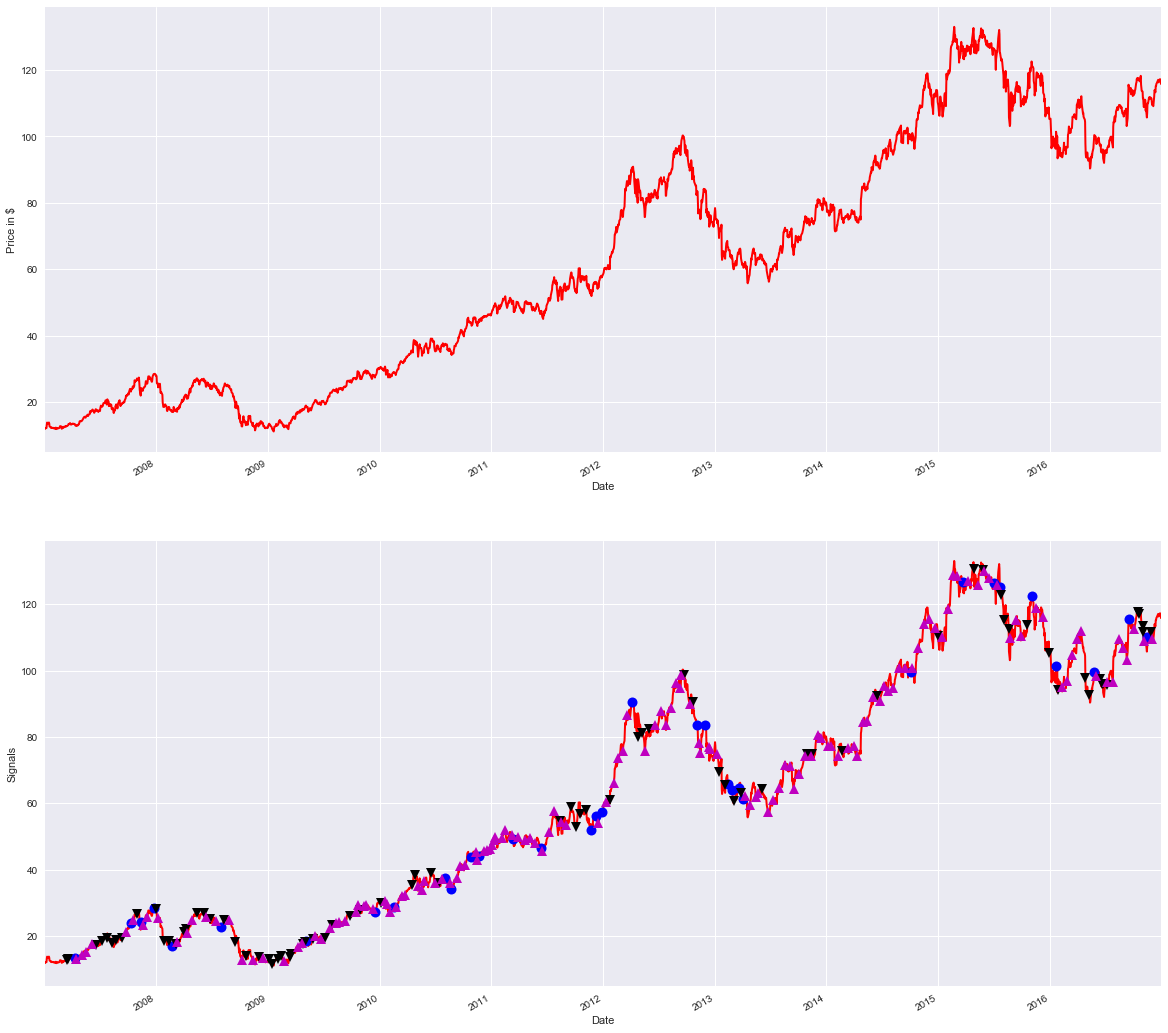

In [14]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211,  ylabel='Price in $')
ax2 = fig.add_subplot(212,  ylabel='Signals')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)
env.data['Close'].plot(ax=ax2, color='r', lw=2.)

ax2.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')

ax2.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax2.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=10, color='m')
       
# Show the plot
plt.show()

In [15]:
agent.save('best_model.h5')

# Backtest

In [40]:
env = Environment('ADBE')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 21, state size: 50


In [41]:
state = env.reset()
state = state.values.reshape([1, state_size])
while env.enough_data_provided():
    action_idx = agent.act(state)
    next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
    next_state = next_state.values.reshape([1, state_size])
    state = next_state

In [42]:
env.score()

19307.71913744355

In [43]:
signals = np.array([[], [], []]).T

In [44]:
for key, value in env.actions.items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-03-16 00:00:00 => Action: buy => Reward: 3.530000000000001
Date: 2007-04-05 00:00:00 => Action: skip => Reward: 0
Date: 2007-04-24 00:00:00 => Action: skip => Reward: 0
Date: 2007-05-10 00:00:00 => Action: buy => Reward: 1.720000000000006
Date: 2007-05-29 00:00:00 => Action: sell => Reward: -0.12000000000000455
Date: 2007-06-12 00:00:00 => Action: buy => Reward: -2.259999999999998
Date: 2007-06-28 00:00:00 => Action: sell => Reward: -1.1299999999999955
Date: 2007-07-13 00:00:00 => Action: buy => Reward: -0.28999999999999915
Date: 2007-07-31 00:00:00 => Action: buy => Reward: 0.5399999999999991
Date: 2007-08-14 00:00:00 => Action: sell => Reward: -1.8400000000000034
Date: 2007-08-30 00:00:00 => Action: buy => Reward: 0.8400000000000034
Date: 2007-09-18 00:00:00 => Action: sell => Reward: -0.28999999999999915
Date: 2007-10-02 00:00:00 => Action: buy => Reward: 1.740000000000002
Date: 2007-10-18 00:00:00 => Action: skip => Reward: 0
Date: 2007-11-05 00:00:00 => Action: buy => R

In [45]:
signals_df = create_signals_df(signals)

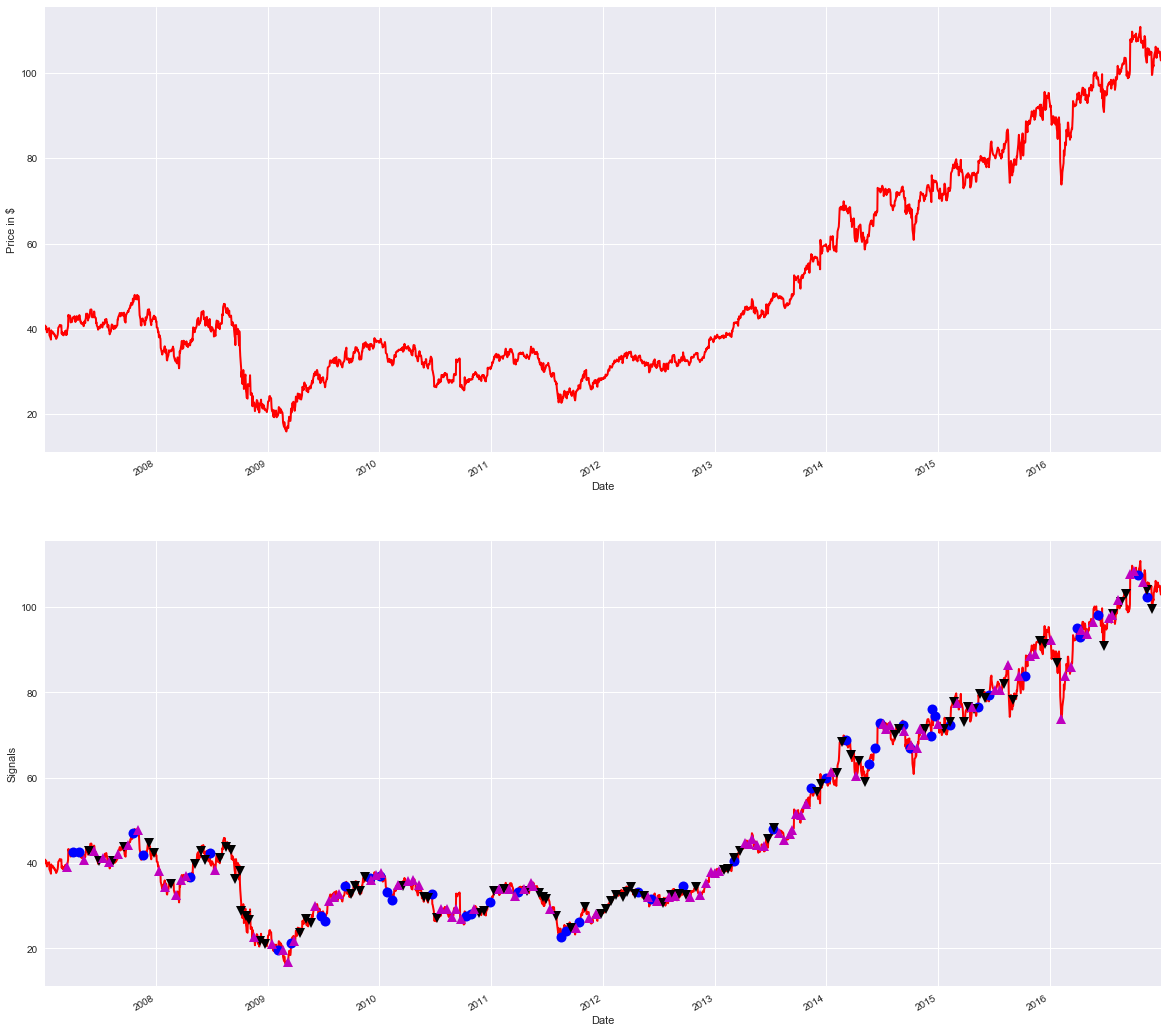

In [46]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211,  ylabel='Price in $')
ax2 = fig.add_subplot(212,  ylabel='Signals')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)
env.data['Close'].plot(ax=ax2, color='r', lw=2.)

ax2.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')

ax2.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax2.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=10, color='m')
       
# Show the plot
plt.show()